CONTINUACAO DO CURSO

In [1]:
!pip install tensorflow

In [17]:
# bibliotecas utilizadas
import cv2 #OpenCV
from google.colab.patches import cv2_imshow
from google.colab import drive
import dlib
from PIL import Image
import numpy as np
import zipfile
from sklearn.metrics import accuracy_score
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, UpSampling2D, Reshape
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Input, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.models import save_model
tf.__version__ #versao do tensorflow

'2.15.0'

In [ ]:
#caso de problema com a versao do tensorflow
#!pip install tensorflow == 2.6.0 #versao usada no curso

In [3]:
# drive
drive.mount('/content/drive')

Mounted at /content/drive


# Projeto 12 - Analise de Sentimentos

> implementacao de RNC

> deteccao de emocao em imagem

> deteccao de emocao em video

> O projeto envolvera diferentes implementacacoes para deteccao de 6 emocoes iniciais.  

In [ ]:
path = '/content/drive/MyDrive/Visão Computacional Guia Completo/Datasets/fer_images.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

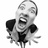

In [ ]:
tf.keras.preprocessing.image.load_img('/content/fer2013/train/Angry/1003.jpg')

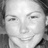

In [ ]:
tf.keras.preprocessing.image.load_img('/content/fer2013/train/Happy/1.jpg')

## Split

In [ ]:
# base de dados de treinamento
gerador_train = ImageDataGenerator(rescale=1./255, #normalizacao
                                         rotation_range=7, #rotacao
                                         horizontal_flip=True, #rotacao horizontal
                                         zoom_range=0.2) #zoom

dataset_train = gerador_train.flow_from_directory('/content/fer2013/train', #criacao do dataset seguindo o modelo da rede neural original
                                                              target_size = (48, 48), #verificar o tamanho das imagens originais.
                                                              batch_size = 16,
                                                              class_mode = 'categorical', #mais de duas classes
                                                              shuffle = True)

Found 28709 images belonging to 7 classes.


In [ ]:
dataset_train.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [ ]:
np.unique(dataset_train.classes, return_counts=True) #classes e quantidade de cada um

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

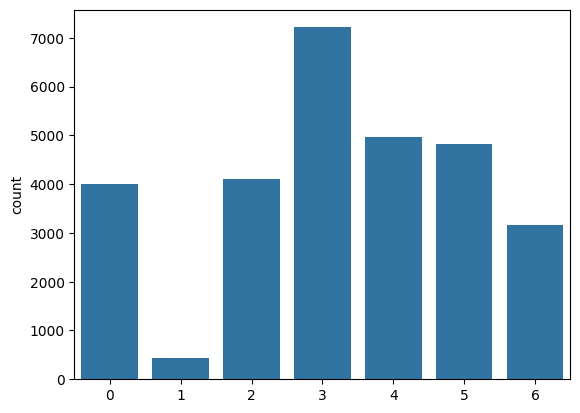

In [ ]:
sns.countplot(x = dataset_train.classes);

In [ ]:
# base de dados de test
gerador_test = ImageDataGenerator(rescale=1./255) #normalizacao

dataset_test = gerador_test.flow_from_directory('/content/fer2013/validation', #criacao do dataset seguindo o modelo da rede neural original
                                                              target_size = (48, 48), #verificar o tamanho das imagens originais.
                                                              batch_size = 1, #passar uma imagem  por  vez
                                                              class_mode = 'categorical', #mais de duas classes
                                                              shuffle = False)

Found 3589 images belonging to 7 classes.


## Contrucao e Treinamento.

In [ ]:
numero_detectores = 32 #quantidade de filtros da rede convolucional.
numero_calsses = 7 #as emocoes
largura, altura = 48,48
epocas = 3

In [ ]:
#arquiterura da rede
rede = Sequential()
rede.add(Conv2D(filters = numero_detectores, kernel_size=(3,3), activation='relu', padding='same', input_shape=(largura, altura, 3))) #primeira camada convolucional
#padding eh a forma como o filtro eh aplicado, nesse caso aproveitando todos os pixels das iamgens
rede.add(BatchNormalization()) #normlizacao dentro da camada
rede.add(Conv2D(filters = numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))#segunda camada convolucional
rede.add(BatchNormalization())
rede.add(MaxPool2D(pool_size=(2,2)))
rede.add(Dropout(0.2)) #evita overfiting zerando 20% dos neuronios

rede.add(Conv2D(filters = 2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same')) #terceira camada convolucional
rede.add(BatchNormalization()) #normlizacao dentro da camada
rede.add(Conv2D(filters = 2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))#quarta camada convolucional
rede.add(BatchNormalization())
rede.add(MaxPool2D(pool_size=(2,2)))
rede.add(Dropout(0.2))

rede.add(Conv2D(filters = 2*2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same')) #quinta camada convolucional
rede.add(BatchNormalization()) #normlizacao dentro da camada
rede.add(Conv2D(filters = 2*2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))#sexta camada convolucional
rede.add(BatchNormalization())
rede.add(MaxPool2D(pool_size=(2,2)))
rede.add(Dropout(0.2))

rede.add(Conv2D(filters = 2*2*2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same')) #setima camada convolucional
rede.add(BatchNormalization()) #normlizacao dentro da camada
rede.add(Conv2D(filters = 2*2*2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))#oitava camada convolucional
rede.add(BatchNormalization())
rede.add(MaxPool2D(pool_size=(2,2)))
rede.add(Dropout(0.2))

rede.add(Flatten())

rede.add(Dense(units=2*numero_detectores, activation = 'relu')) #primeira cadama oculta
rede.add(BatchNormalization())
rede.add(Dropout(0.2))

rede.add(Dense(units=2*numero_detectores, activation = 'relu')) #segunda cadama oculta
rede.add(BatchNormalization())
rede.add(Dropout(0.2))

rede.add(Dense(units=numero_calsses, activation = 'softmax')) #camada de saida
print(rede.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_10 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_11 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

In [ ]:
rede.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
rede.fit(dataset_train, epochs=epocas)

Epoch 1/3
1795/1795 [==============================] - 81s 34ms/step - loss: 1.8518 - accuracy: 0.2678
Epoch 2/3
1795/1795 [==============================] - 56s 31ms/step - loss: 1.5569 - accuracy: 0.3930
Epoch 3/3
1795/1795 [==============================] - 57s 32ms/step - loss: 1.3979 - accuracy: 0.4655


## Salvar e carregar a RN

In [ ]:
#model_json = network.to_json()
#with open('network_emotions.json','w') as json_file:
  #json_file.write(model_json)

In [ ]:
#network_saved = save_model(network, '/content/weights_emotions.hdf5')

In [ ]:
#carregar modelo pronto
with open('/content/drive/MyDrive/Visão Computacional Guia Completo/Weights/network_emotions.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_8_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d_8", "trainable": true, "batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "BatchNormalization", "config": {"name": "batch_normalization_8", "trainable": true, "dtype": "float32", "axis": [3], "momentum": 0.99, "epsilon": 0

In [ ]:
rede_loaded = tf.keras.models.model_from_json(json_saved_model) #modelo
rede_loaded.load_weights('/content/drive/MyDrive/Visão Computacional Guia Completo/Weights/weights_emotions.hdf5') #pesos
rede_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
rede_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_9 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

## Avaliação da rede neural

In [ ]:
# forma rapida de avaliar o modelo
rede_loaded.evaluate(dataset_test)

3589/3589 [==============================] - 28s 7ms/step - loss: 1.5148 - accuracy: 0.5779


[1.5148497819900513, 0.5778768658638]

In [ ]:
previsoes = rede_loaded.predict(dataset_test)
previsoes
#cada uma das imagens eh retornada yum vetor de 7 posicoes

3589/3589 [==============================] - 23s 6ms/step


array([[9.13990259e-01, 5.24317101e-03, 2.00650208e-02, ...,
        7.55342515e-03, 3.91561240e-02, 1.23086749e-02],
       [8.34895313e-01, 1.31147943e-04, 1.60493657e-01, ...,
        8.83346482e-04, 3.42258206e-03, 1.44678467e-07],
       [9.68744576e-01, 7.42953096e-04, 1.70952734e-02, ...,
        1.25664158e-03, 7.57124368e-03, 4.92689491e-04],
       ...,
       [1.75535586e-03, 4.70192317e-05, 4.10514139e-02, ...,
        1.66567741e-03, 2.93833646e-03, 9.52457905e-01],
       [2.91052531e-03, 4.30332548e-05, 6.92667887e-02, ...,
        3.61312360e-01, 3.13797593e-03, 5.30261457e-01],
       [2.68193465e-02, 2.26625754e-03, 1.13005705e-01, ...,
        4.77516092e-03, 7.12134037e-03, 8.45583379e-01]], dtype=float32)

In [ ]:
previsoes = np.argmax(previsoes, axis=1)
previsoes

array([0, 0, 0, ..., 6, 6, 6])

In [ ]:
accuracy_score(dataset_test.classes, previsoes)

0.5778768459180831

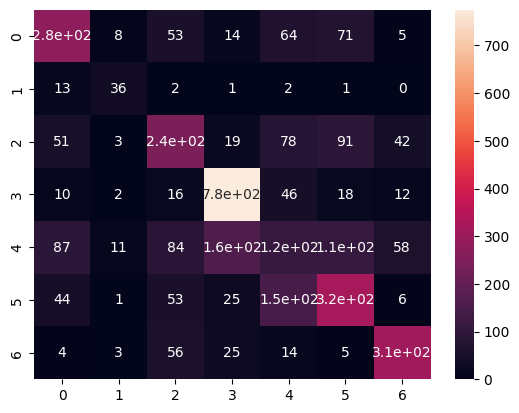

In [ ]:
cm = confusion_matrix(dataset_test.classes, previsoes)
sns.heatmap(cm, annot=True);

In [ ]:
print(classification_report(dataset_test.classes, previsoes))

              precision    recall  f1-score   support

           0       0.57      0.56      0.57       491
           1       0.56      0.65      0.61        55
           2       0.48      0.46      0.47       528
           3       0.76      0.88      0.82       879
           4       0.25      0.18      0.21       626
           5       0.52      0.54      0.53       594
           6       0.72      0.74      0.73       416

    accuracy                           0.58      3589
   macro avg       0.55      0.57      0.56      3589
weighted avg       0.56      0.58      0.56      3589



## Classificacao de uma imagem

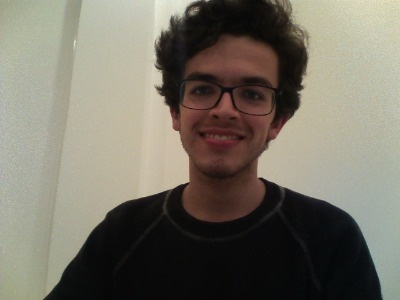

In [ ]:
imagem = cv2.imread('/content/drive/MyDrive/Visão Computacional Guia Completo/Images/gabriel.png')
cv2_imshow(imagem)

In [ ]:
imagem.shape

(300, 400, 3)

In [ ]:
#eh preciso enviar apenas a face, nao a foto inteira.
#carregar um detector de faces
detector_face = cv2.CascadeClassifier('/content/drive/MyDrive/Visão Computacional Guia Completo/Cascades/haarcascade_frontalface_default.xml')

In [ ]:
imagem_original = imagem.copy() #copia
deteccoes = detector_face.detectMultiScale(imagem_original) #detecoess encontradas

In [ ]:
deteccoes #bounding box de onde a face foi detectada

array([[162,  40, 128, 128]], dtype=int32)

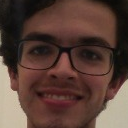

In [ ]:
#extrair o que ha dentro do bounding box
roi = imagem[40:40+128, 162:162+128] #region of interest
cv2_imshow(roi)

In [ ]:
roi.shape

(128, 128, 3)

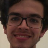

In [ ]:
#redimensionar a imagem
roi = cv2.resize(roi,(48,48)) #tamanho que a rede neural foi treinada
cv2_imshow(roi)

In [ ]:
roi.shape

(48, 48, 3)

array([[[ 28,  32,  37],
        [ 22,  28,  34],
        [ 33,  37,  42],
        ...,
        [ 12,  16,  17],
        [ 16,  21,  25],
        [ 16,  25,  30]],

       [[ 27,  31,  36],
        [ 31,  36,  41],
        [ 32,  36,  41],
        ...,
        [ 11,  16,  19],
        [ 13,  19,  24],
        [ 17,  25,  28]],

       [[ 27,  31,  36],
        [ 30,  34,  39],
        [ 26,  30,  35],
        ...,
        [ 12,  17,  20],
        [ 14,  20,  25],
        [ 20,  25,  27]],

       ...,

       [[162, 185, 197],
        [166, 188, 200],
        [166, 188, 200],
        ...,
        [162, 181, 188],
        [162, 182, 188],
        [161, 180, 187]],

       [[160, 184, 196],
        [165, 187, 199],
        [166, 188, 200],
        ...,
        [161, 180, 187],
        [162, 181, 187],
        [161, 180, 187]],

       [[160, 184, 196],
        [163, 187, 199],
        [165, 187, 199],
        ...,
        [160, 179, 186],
        [161, 180, 187],
        [162, 181, 188]]], dtype=uint8)
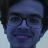

In [ ]:
roi

In [ ]:
# normalizacao entre 0 e 1
roi = roi/255

In [ ]:
#add uma dimensao a mais no incio que significa o batch, ou seja, a quantidade de imagem que sera enviada a rede, nesse caso, 1 apenas
roi = np.expand_dims(roi, axis=0)
roi.shape

(1, 48, 48, 3)

In [ ]:
probs = rede_loaded.predict(roi)
probs

1/1 [==============================] - 0s 460ms/step


array([[5.2841782e-04, 1.1444075e-06, 1.2489490e-03, 8.9390194e-01,
        1.0206461e-01, 2.1787002e-03, 7.6220604e-05]], dtype=float32)

In [ ]:
previsao = np.argmax(probs)
previsao #indice de maior valor encontrado
#3 = happy

3

## Classificação de múltiplas imagens

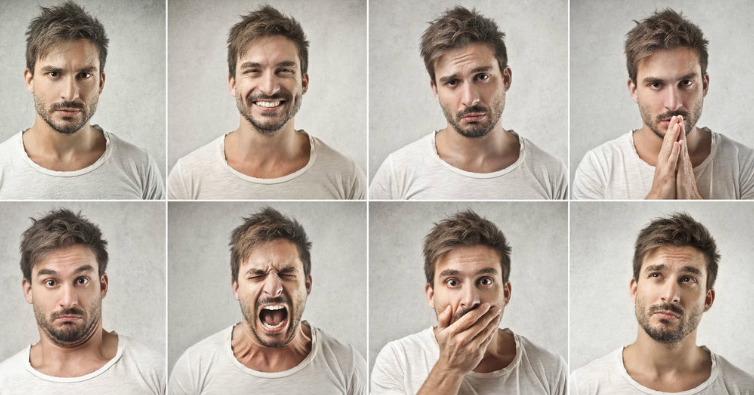

In [ ]:
imagem = cv2.imread('/content/drive/MyDrive/Visão Computacional Guia Completo/Images/faces_emotions.png')
cv2_imshow(imagem)

In [ ]:
deteccoes = detector_face.detectMultiScale(imagem) #detector
deteccoes
# 8 bounding box

array([[224,  35,  90,  90],
       [ 23,  41,  92,  92],
       [625,  49,  91,  91],
       [420,  43,  97,  97],
       [229, 242,  85,  85],
       [420, 242,  97,  97],
       [627, 241,  91,  91],
       [ 18, 243,  98,  98]], dtype=int32)

In [ ]:
dataset_test.class_indices.keys()

dict_keys(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

In [ ]:
dataset_test.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [ ]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

1/1 [==============================] - 0s 31ms/step


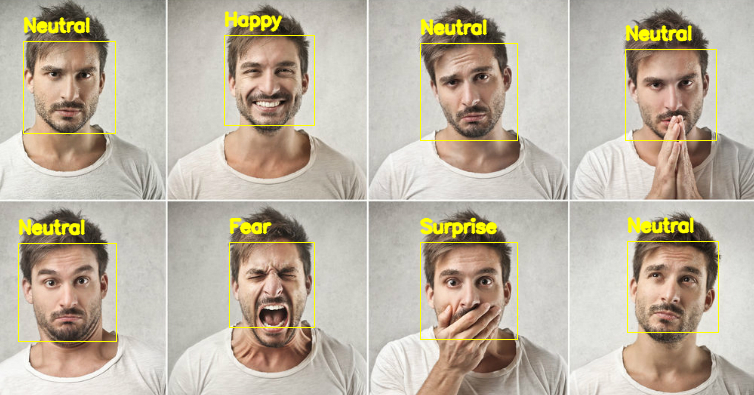

In [ ]:
for (x,y,w,h) in deteccoes:
  #print(x,y,w,h)
  cv2.rectangle(imagem, (x,y), (x+w, y+h), (0,255,255),1)
  roi = imagem[y:y+h, x:x+w] #extracao da parte interessada
  roi = cv2.resize(roi, (48,48))
  roi = roi/255
  roi = np.expand_dims(roi, axis=0)
  previsao = rede_loaded.predict(roi)
  cv2.putText(imagem, emotions[np.argmax(previsao)], (x,y -10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 2, cv2.LINE_AA)

cv2_imshow(imagem)

## Classificação de emocoes em um video

In [ ]:
#leitura do primeiro frame do video
cap = cv2.VideoCapture('/content/drive/MyDrive/Visão Computacional Guia Completo/Videos/emotion_test01.mp4')
conectado, video = cap.read()
print(conectado, video.shape)
#true eh video lido com sucesso

True (360, 640, 3)


In [ ]:
save_path = ('/content/drive/MyDrive/Visão Computacional Guia Completo/Videos/emotion_test01_resulto.avi')
fourcc = cv2.VideoWriter_fourcc(*'XVID') #um codec para salvar videos
fps=24 #frames per second
output_video = cv2.VideoWriter(save_path, fourcc, fps, (video.shape[1], video.shape[0])) #variavel que grava o video dps de ser processado

In [ ]:
while (cv2.waitKey(1)<0): #codigo para processar cada um dos frames do video
  conectado, frame = cap.read()
  if not conectado:
    break

  deteccoes = detector_face.detectMultiScale(frame, scaleFactor=1.2, minNeighbors = 5, minSize=(30,30))
  if len(deteccoes)>0: #se ha alguma face
    for (x,y,w,h) in deteccoes:
      frame = cv2.rectangle(frame, (x, y), (x + w, y + h), (0,255,0), 2) #desenha o retangulo
      roi = frame[y:y + h, x:x + w] #encontra a face
      roi = cv2.resize(roi, (48,48)) #redimensiona para a rede
      roi = roi / 255 #normaliza
      roi = np.expand_dims(roi, axis = 0) #add uma dimensao
      previsao = rede_loaded.predict(roi) #faz a previsao

      if previsao is not None: #se for encontrada alguma coisa, escreve na iamgem
        resultado = np.argmax(previsao)
        cv2.putText(frame, emotions[resultado], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)

  cv2_imshow(frame)
  output_video.write(frame)


print('fim')
output_video.release()#liberar a memoria
cv2.destroyAllWindows()

# Projeto 13 - Autoencoders

> autoencoders possui uma camada de entrada, uma camada oculta e uma camada de saida (ligando todos os neuronios). O nome significa codificacao, ou seja, uma codificacao automatica da base de dados.

> da camada de entrada para a oculta: Codificacao

> da camada oculta para a de saida: Decodificacao

> o precesso se parece muito com uma RN feedfoawrd, considerado uma tecnica de apredizagem nao supervisionada.

> Chamado de Self Supervised Learning, pois ele aprende sozinho.

> a quantidade de entrada eh a mesma de saida.

> a camada oculta pode ser maior que as camadas de entrada e saida, extraindo mais dados dos dados.

> Sparse autoencoder - camada oculta dobro das camadas de entrada e saida. Nao utiliza todos os neuronios. Uma forma de conter o overfitting.

> Denoising Autoencoder - mesmo tamanho das camadas. Esse modifica valores da camada de entrada, alterando alguns neuronios para o valor zero. O erro é obtido comparando o resultado da camada de saida com os valores de entrada.

> Contractive autoencoder - add uma funcaoi de penalidade quando os pesos sao atualizados. Essa penalidade é usada para calcular o erro.

> Deep autoencooder (stack) - um ampulheta deitada. Camada do meio é chamada de Compressed Feature Vector.

> Convolutional autoencoder - assemelhasse a uma RNC, formato espelho tbm. Vai reduzindoo as dimensionalidades, aplica o flatten e dps faz o fluxo inverso.

## Projeto 13.1 - Autoencoder Linear

### Carregar dados

uma base famosa do keras sera utilizada, chamada mnist

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [ ]:
#quantidade de pixels
28*28

784

In [ ]:
X_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [ ]:
#possui duas dimensoes, uma para linha e uma para coluna.
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170,
        253, 253, 253, 253, 253, 225, 172, 253, 242, 195,  64,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  49, 238, 253, 253, 253, 253,
        253, 253, 253, 253, 251,  93,  82,  82,  56,  39,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  18, 219, 253, 253, 253, 253,
        253, 198, 182, 247, 241,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  80, 156, 107, 253, 253,
        205,  11,   0,  43, 154,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  14,   1, 154, 253,
         90,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 139, 253,
        190,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11, 190,
        253,  70,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35,
        241, 225, 160, 108,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         81, 240, 253, 253, 119,  25,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  45, 186, 253, 253, 150,  27,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  16,  93, 252, 253, 187,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 249, 253, 249,  64,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  46, 130, 183, 253, 253, 207,   2,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  39,
        148, 229, 253, 253, 253, 250, 182,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  24, 114, 221,
        253, 253, 253, 253, 201,  78,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  23,  66, 213, 253, 253,
        253, 253, 198,  81,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  18, 171, 219, 253, 253, 253, 253,
        195,  80,   9,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  55, 172, 226, 253, 253, 253, 253, 244, 133,
         11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 136, 253, 25

In [ ]:
y_train[0]

5

### Visualizar as imagens

Classe eh: 1


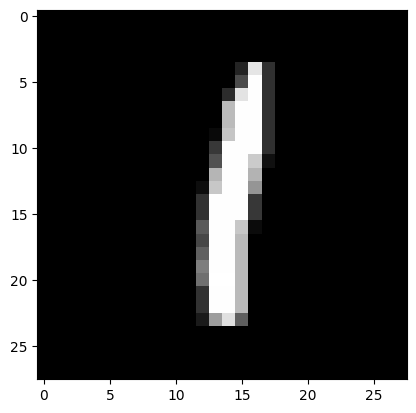

In [ ]:
i = np.random.randint(0,60000)
plt.imshow(X_train[i], cmap='gray');
print(f'Classe eh: {y_train[i]}')

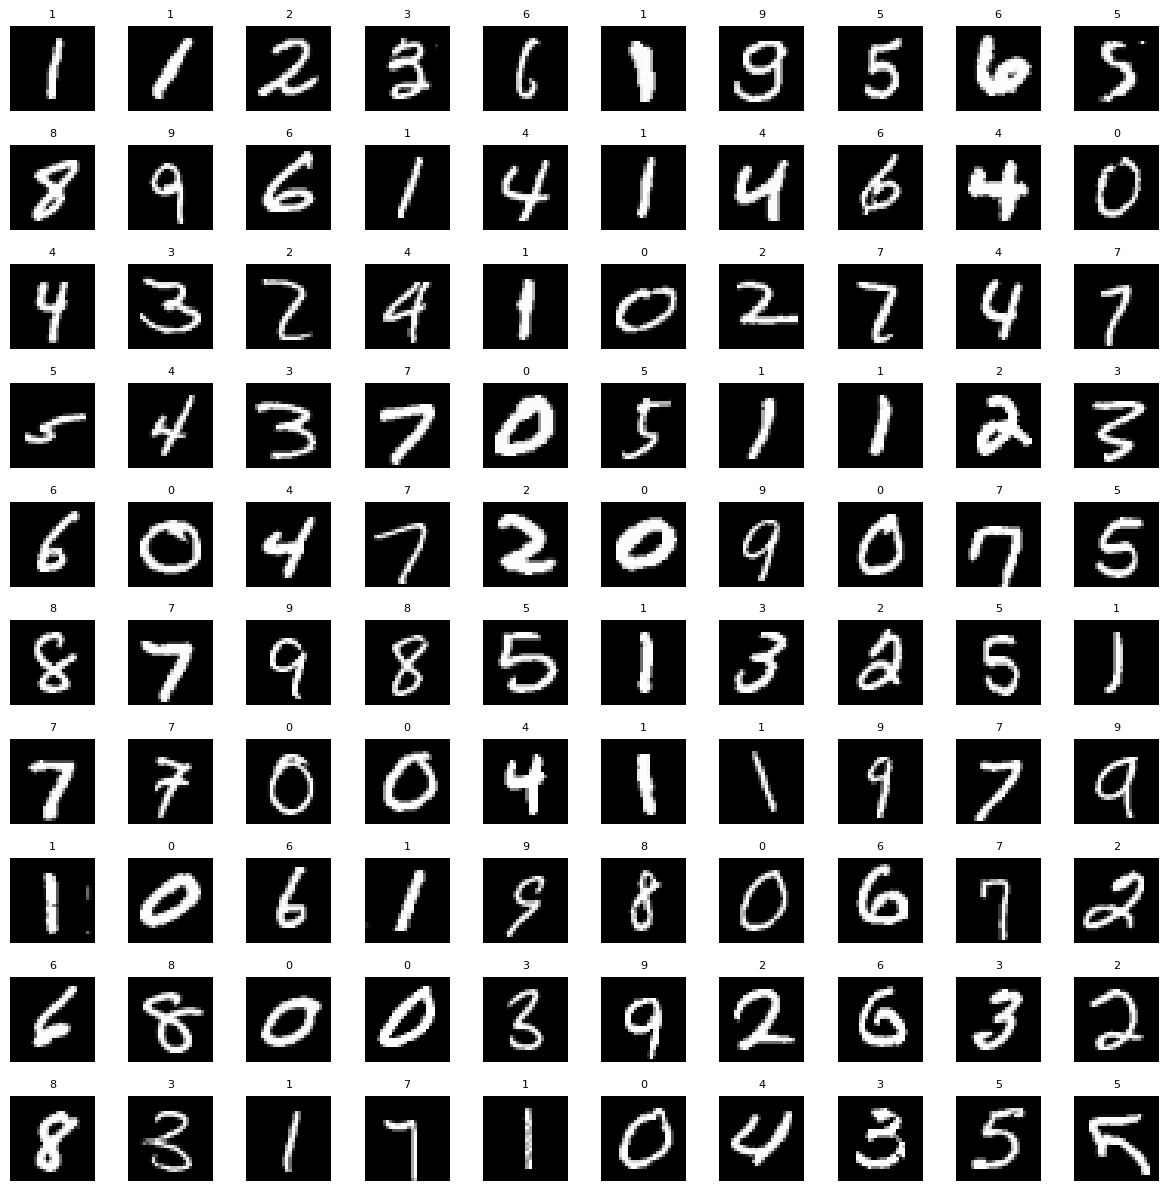

In [ ]:
#subplot em matriz
largura = 10
altura = 10

figura, axes = plt.subplots(altura, largura, figsize=(15,15))
axes = axes.ravel() #tranformando de matriz para vetor
for i in np.arange(0,100):
  indice = np.random.randint(0,60000)
  axes[i].imshow(X_train[indice], cmap='gray')
  axes[i].set_title(y_train[indice], fontsize=8)
  axes[i].axis('off') #desliga os eixos
plt.subplots_adjust(hspace=0.4)#espaco entre as imagens

### Pre-processamento das imagens

In [ ]:
#normalizacao
X_train = X_train/255
X_test = X_test/255

In [ ]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

Para enviar a imagem para o encoder eh preciso enviar todos os pixels, convertando matriz em vetor.

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]) #vetor
X_train.shape

(60000, 784)

In [ ]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]) #vetor
X_test.shape

(10000, 784)

### Construcao e treinamento do autoencoder

In [ ]:
#arquitetura: 784 - 128 - 64 - 32 - 64 - 128 - 784 -> Deep autoencoder

autoencoder = Sequential()

#Codificacao
autoencoder.add(Dense(units = 128, activation = 'relu', input_dim = 784)) #primeira camada oculta
autoencoder.add(Dense(units = 64, activation = 'relu')) #segunda camada oculta
autoencoder.add(Dense(units = 32, activation = 'relu')) #camada onde estara codificada a imagem

#Decodificacao
autoencoder.add(Dense(units = 64, activation = 'relu'))
autoencoder.add(Dense(units = 128, activation = 'relu'))
autoencoder.add(Dense(units = 784, activation = 'sigmoid')) #devido a normalizacao que ficou de entre 0 e 1.

In [ ]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 784)               101136    
                                                                 
Total params: 222384 (868.69 KB)
Trainable params: 22238

In [ ]:
autoencoder.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
autoencoder.fit(X_train, X_train, epochs=50) #nao usa-se o y_train aqui pois os pixels da camada de entrada tem que ser os mais proximos da camada de saida.

#nao se atentar ao valor do acuraccy, pois nesse caso ah 784 classes praticamente. A avalaicao desse algoritmo eh observando as imagens geradas por meio da compactacao e descompactacao

Epoch 1/50
1875/1875 [==============================] - 19s 9ms/step - loss: 0.1535 - accuracy: 0.0114
Epoch 2/50
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1102 - accuracy: 0.0128
Epoch 3/50
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1015 - accuracy: 0.0125
Epoch 4/50
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0969 - accuracy: 0.0124
Epoch 5/50
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0940 - accuracy: 0.0131
Epoch 6/50
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0917 - accuracy: 0.0137
Epoch 7/50
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0898 - accuracy: 0.0142
Epoch 8/50
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0885 - accuracy: 0.0146
Epoch 9/50
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0875 - accuracy: 0.0149
Epoch 10/50
1875/1875 [==============================] - 14s 7ms/step -

### Codificacao das imagens

In [ ]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 784)               101136    
                                                                 
Total params: 222384 (868.69 KB)
Trainable params: 22238

In [ ]:
autoencoder.input #camada de entrada

<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'dense_input')>

In [ ]:
autoencoder.get_layer('dense_2').output #pegar o resultado da camada onde acontece a codificacao das imagens
#bucas camada pelo nome

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_2')>

In [ ]:
encoder = Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('dense_2').output) #codificador
#uma nova rede neural criada para codificar imagens

In [ ]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (InputLayer)    [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
Total params: 110816 (432.88 KB)
Trainable params: 110816 (432.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


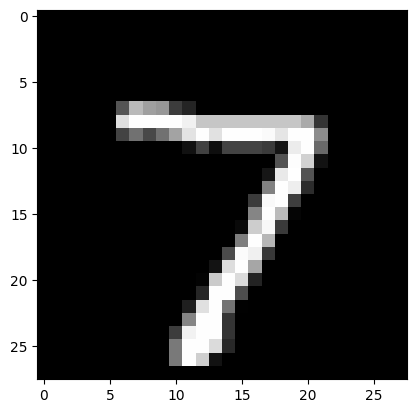

In [ ]:
plt.imshow(X_test[0].reshape(28,28), cmap='gray'); #tranformar em matriz para aparecer a imagem

In [ ]:
X_test[0].shape #shape original

(784,)

In [ ]:
#transformar o shape para enviar para a rede
X_test[0].reshape(1,-1).shape

(1, 784)

In [ ]:
imagem_cod = encoder.predict(X_test[0].reshape(1,-1))

1/1 [==============================] - 0s 186ms/step


In [ ]:
imagem_cod

array([[ 1.2087659,  4.400303 ,  0.       ,  5.217492 ,  5.9988623,
         8.595915 ,  6.7333474,  5.1110287,  5.698827 ,  6.6807923,
         4.359658 ,  0.4141627,  2.2426546,  2.0807815,  4.60308  ,
         8.298915 ,  6.2371345,  0.       ,  3.4047942,  5.5686927,
         3.845266 ,  2.6331708,  0.       , 10.10493  ,  0.6131483,
         2.835982 ,  2.9945118,  3.3847249,  5.140282 ,  1.875534 ,
         0.       ,  5.026048 ]], dtype=float32)

In [ ]:
imagem_cod.shape

(1, 32)

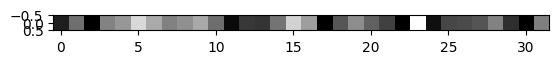

In [ ]:
plt.imshow(imagem_cod, cmap='gray'); #vetor de 32 pixels

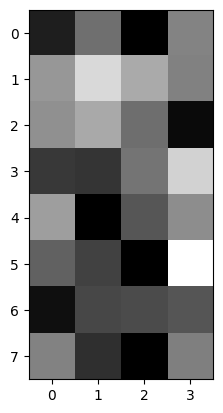

In [ ]:
plt.imshow(imagem_cod.reshape(8,4), cmap='gray'); #8*4 = 32

### Decodificao das imagens

processo inverso agora

In [ ]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 784)               101136    
                                                                 
Total params: 222384 (868.69 KB)
Trainable params: 22238

In [ ]:
input_layer_decoder = Input(shape=(32,)) #criar camada de entrada
decoder_layer1 = autoencoder.layers[3] #busca camada pelo indice 64
decoder_layer2 = autoencoder.layers[4] #128
decoder_layer3 = autoencoder.layers[5] #784

decoder = Model(inputs = input_layer_decoder, outputs = decoder_layer3(decoder_layer2(decoder_layer1(input_layer_decoder)))) #ligacao de camadas

In [ ]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 784)               101136    
                                                                 
Total params: 111568 (435.81 KB)
Trainable params: 111568 (435.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
imagem_decod = decoder.predict(imagem_cod)

1/1 [==============================] - 0s 97ms/step


In [ ]:
imagem_decod.shape

(1, 784)

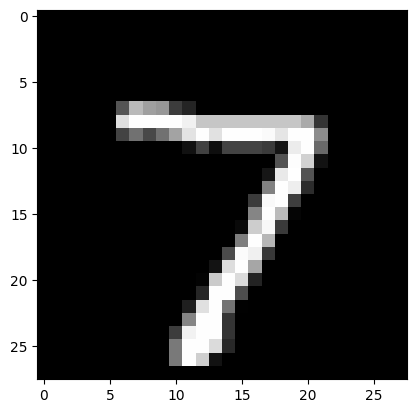

In [ ]:
#imagem original
plt.imshow(X_test[0].reshape(28,28), cmap='gray');

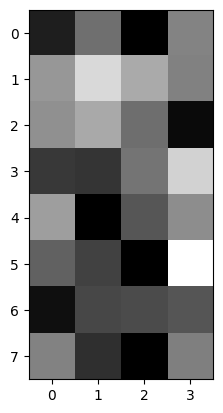

In [ ]:
#imagem codificada
plt.imshow(imagem_cod.reshape(8,4), cmap='gray');

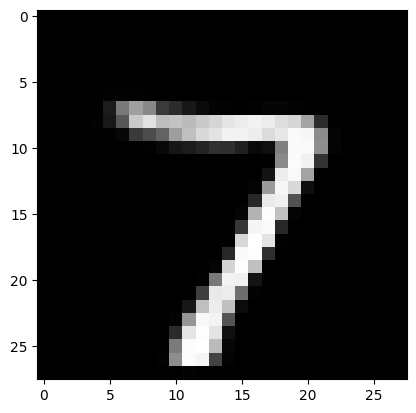

In [ ]:
plt.imshow(imagem_decod.reshape(28,28), cmap='gray');

### Cod e Decod nas imagens de Teste

1/1 [==============================] - 0s 22ms/step


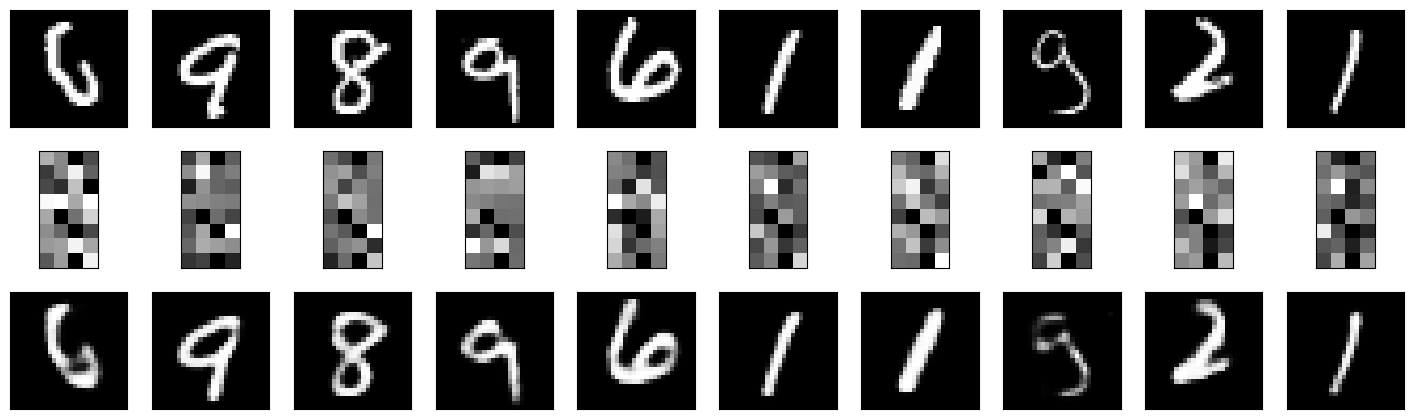

In [ ]:
#forma de avaliar o autoencoder

numero_imagens = 10
imagens_test = np.random.randint(0,10000, size = numero_imagens) #10 numeros aleatorios entre 0 e 10k
#print(imagens_test)

plt.figure(figsize=(18,18))
for i, imagem_indice in enumerate(imagens_test):
  #print(i, imagem_indice)

  #imagens originais
  ax = plt.subplot(10,10, i+1) #i+1 eh o indice do subgrafico
  plt.imshow(X_test[imagem_indice].reshape(28,28), cmap = 'gray')
  plt.xticks(()) #remove os numeros do eixo x
  plt.yticks(()) #remove os numeros do eixo y

  #imagens cod
  ax = plt.subplot(10,10, i+1+numero_imagens) #eh add o numero_imagens apenas para obter indices diferentes dos atenriores
  imagem_cod = encoder.predict(X_test[imagem_indice].reshape(1,-1))
  plt.imshow(imagem_cod.reshape(8,4), cmap='gray')
  plt.xticks(())
  plt.yticks(())

  #imagens decod
  ax = plt.subplot(10,10, i+1+numero_imagens*2) #eh add o numero_imagens*2 apenas para obter indices diferentes dos atenriores
  plt.imshow(decoder.predict(imagem_cod).reshape(28,28), cmap='gray')
  plt.xticks(())
  plt.yticks(())

## Projeto 13.2 - Autoencoder Convolucional

### Carregar dados

In [7]:
from tensorflow.keras.datasets import fashion_mnist

In [8]:
(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [9]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [11]:
X_test.shape, y_test.shape

((10000, 28, 28), (10000,))

### Vizualizar as imagens

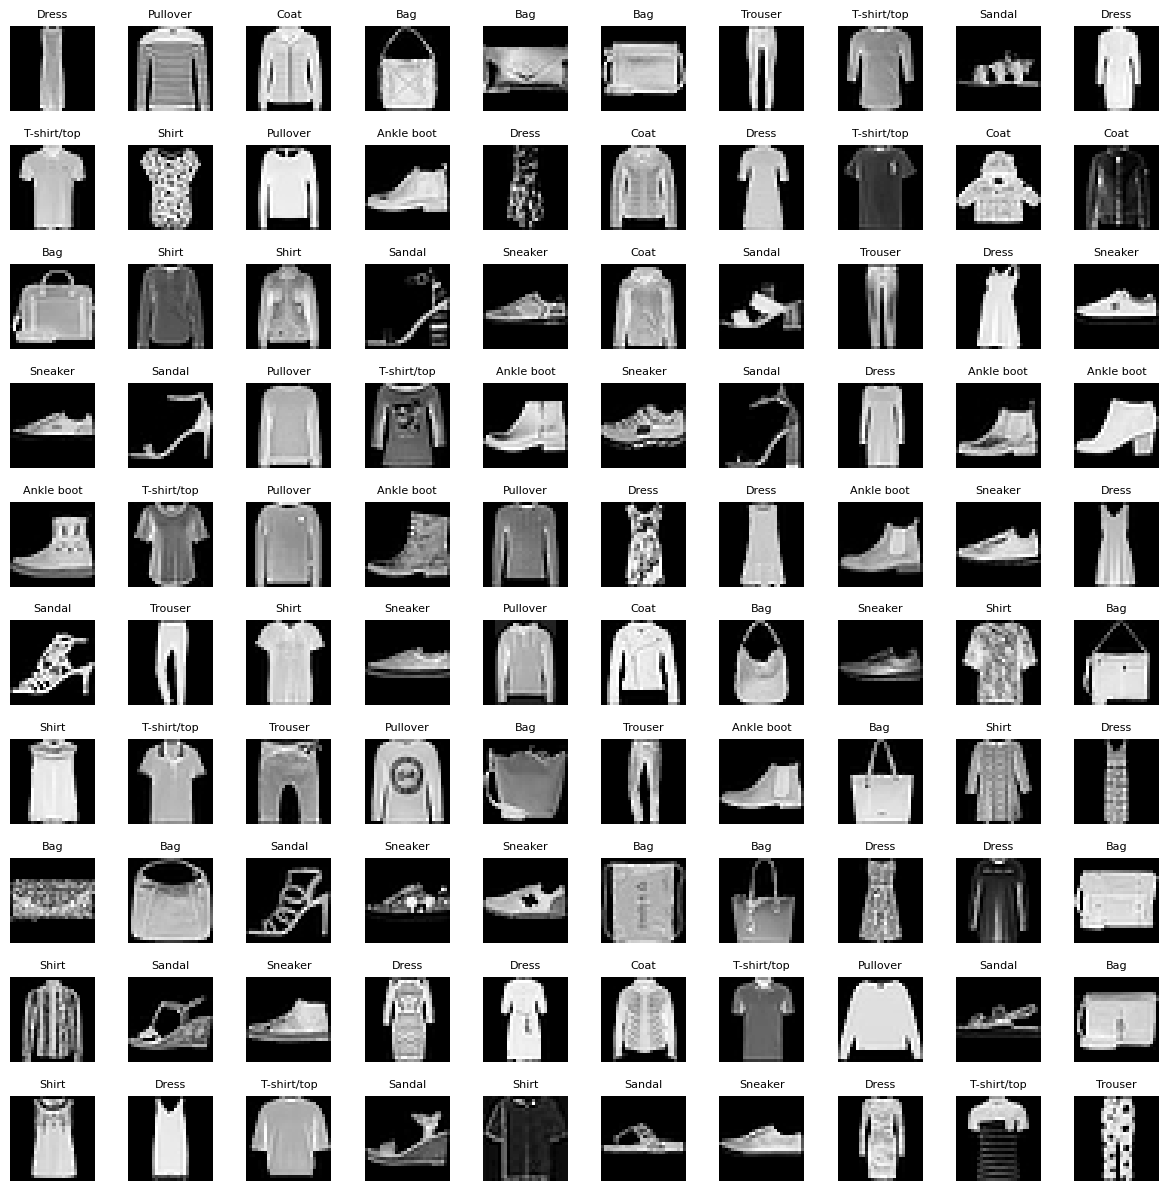

In [12]:
#subplot em matriz
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
largura = 10
altura = 10

figura, axes = plt.subplots(altura, largura, figsize=(15,15))
axes = axes.ravel() #tranformando de matriz para vetor
for i in np.arange(0,100):
  indice = np.random.randint(0,60000)
  axes[i].imshow(X_train[indice], cmap='gray')
  axes[i].set_title(classes[y_train[indice]], fontsize=8)
  axes[i].axis('off') #desliga os eixos
plt.subplots_adjust(hspace=0.4)#espaco entre as imagens

### Pre-processamento das imagens

In [13]:
#normalizacao
X_train = X_train/255
X_test = X_test/255

In [14]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [15]:
#adicicao do canal das cores
X_train = X_train.reshape((len(X_train), 28, 28, 1))
X_test = X_test.reshape((len(X_test), 28, 28, 1))

In [16]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### Contrucao e treinamento do autoencoder

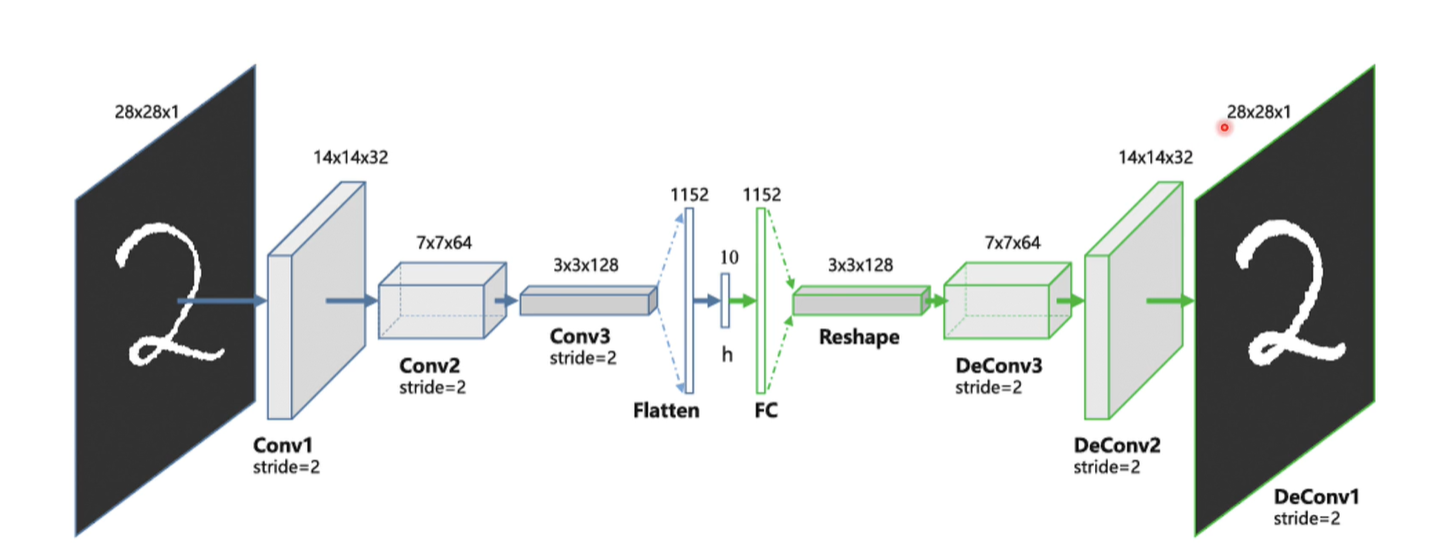

parametros de padding:
* Same: nao se perde info da imagem
* Valid: perde alguma info da imagem (Default)

In [29]:
#Arquitetura do autoencoder
autoencoder = Sequential()

#Encoder
autoencoder.add(Conv2D(filters = 16, kernel_size=(3,3), activation = 'relu', padding = 'valid', input_shape = (28,28,1))) #primeira camada convolucional
#o parametro valid faz ter uma perda de algumas colunas, pois nao faz a adição de colunas zeradas como é o caso do SAME
autoencoder.add(MaxPooling2D(pool_size = (2,2)))

autoencoder.add(Conv2D(filters = 8, kernel_size=(3,3), activation = 'relu', padding = 'same')) #segunda camada convolucional
autoencoder.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))

autoencoder.add(Conv2D(filters = 8, kernel_size=(3,3), activation = 'relu', padding = 'same', strides=(2,2)))
#strides indica como sera o deslocamento do detector de caracteristicas, reduzindo a dimensionalidade da imagem sem ter que aplicar Maxpolling

autoencoder.add(Flatten())#vetor, imagem codificada


#Decoder
autoencoder.add(Reshape((4,4,8))) #de vetor para matriz, aumento de dimensionalidade apenas

autoencoder.add(Conv2D(filters = 8, kernel_size=(3,3), activation = 'relu', padding = 'same'))
autoencoder.add(UpSampling2D((2,2))) #aumento de dimensionalidade

autoencoder.add(Conv2D(filters = 8, kernel_size=(3,3), activation = 'relu', padding = 'same'))
autoencoder.add(UpSampling2D((2,2)))

autoencoder.add(Conv2D(filters = 16, kernel_size=(3,3), activation = 'relu'))
autoencoder.add(UpSampling2D((2,2)))

autoencoder.add(Conv2D(filters = 1, kernel_size=(3,3), activation = 'relu', padding = 'same')) #apenas um canal de cor de saida

autoencoder.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 13, 13, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 7, 7, 8)           0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 4, 4, 8)           584       
                                                                 
 flatten_10 (Flatten)        (None, 128)             

In [ ]:
#tamanho do imagem ao se utilizar o valid

# Output = (Input - Filter + 1) / Stride

#Exemplo:
#input: (28,28,1)
#filter size: 3
#output = (28 - 3 + 1) / 1 = 26

In [31]:
autoencoder.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [32]:
autoencoder.fit(X_train, X_train, epochs = 50)

Epoch 1/50
1875/1875 [==============================] - 18s 5ms/step - loss: 0.3634 - accuracy: 0.5001
Epoch 2/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3693 - accuracy: 0.4992
Epoch 3/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3426 - accuracy: 0.5006
Epoch 4/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3372 - accuracy: 0.5012
Epoch 5/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3365 - accuracy: 0.5010
Epoch 6/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3262 - accuracy: 0.5019
Epoch 7/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3183 - accuracy: 0.5024
Epoch 8/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3141 - accuracy: 0.5027
Epoch 9/50
1875/1875 [==============================] - 12s 6ms/step - loss: 0.3136 - accuracy: 0.5030
Epoch 10/50
1875/1875 [==============================] - 9s 5ms/step - los

### Codificação e Decodificação das imagens

In [33]:
autoencoder.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 13, 13, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 7, 7, 8)           0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 4, 4, 8)           584       
                                                                 
 flatten_10 (Flatten)        (None, 128)             

In [34]:
encoder = Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('flatten_10').output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_50 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 13, 13, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 7, 7, 8)           0         
 ng2D)                                                           
                                                             

In [35]:
imagens_teste_cod = encoder.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [36]:
imagens_teste_cod.shape
#quantidade de imagens e tamanho delas

(10000, 128)

In [37]:
#dessa forma nao precisa criar um decodificador como feito anteriormente
imagens_teste_decod = autoencoder.predict(X_test)

313/313 [==============================] - 2s 4ms/step


In [38]:
imagens_teste_decod.shape

(10000, 28, 28, 1)

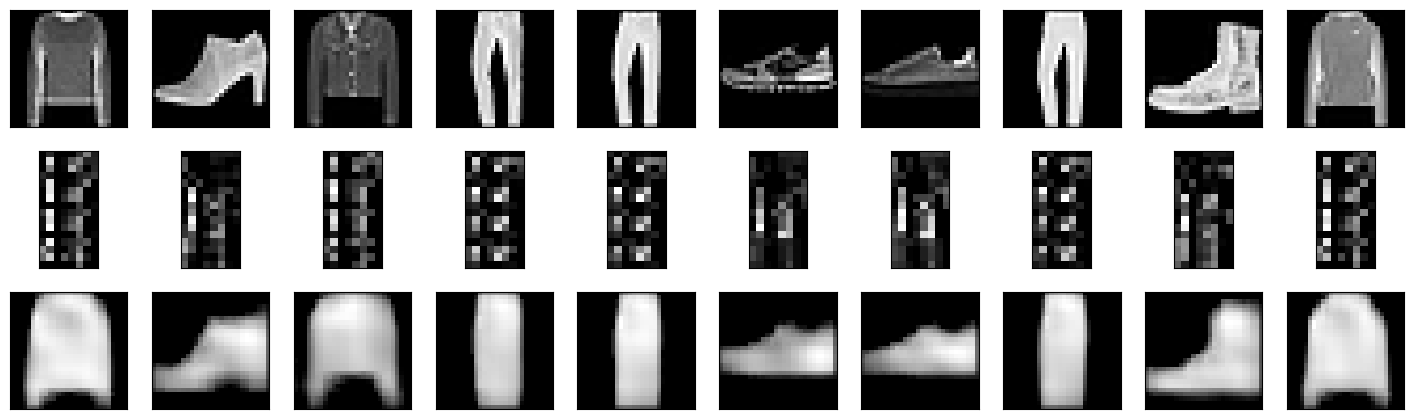

In [44]:
numero_imagens = 10
imagens_test = np.random.randint(0,10000, size = numero_imagens)
plt.figure(figsize=(18,18))
for i, imagem_indice in enumerate(imagens_test):
  #imagem original
  ax = plt.subplot(10,10,i+1)
  plt.imshow(X_test[imagem_indice].reshape(28,28), cmap = 'gray')
  plt.xticks(())
  plt.yticks(())

  #imagem codificadas
  ax = plt.subplot(10,10,i+1+numero_imagens)
  plt.imshow(imagens_teste_cod[imagem_indice].reshape(16,8), cmap = 'gray')
  plt.xticks(())
  plt.yticks(())

  #imagem decodificadas
  ax = plt.subplot(10,10,i+1+numero_imagens*2)
  plt.imshow(imagens_teste_decod[imagem_indice].reshape(28,28), cmap = 'gray')
  plt.xticks(())
  plt.yticks(())

nao esta tao bom por conta das epocas.